# Project Planning

- Describe the project and goals.

- Task out how you will work through the pipeline in as much detail as you need to keep on track.

- Incluce a data dictionary.

- Clearly state your starting hypotheses (and add the testing of these to your task list).

## Goals

- Find drivers for customer churn.

- Construct a ML classification model that accurately predicts customer churn.

- Create modules that make your process repeateable.

- Document your process well enough to be presented or read like a report.



## Audience

- Your target audience for your notebook walkthrough is the Codeup Data Science team. This should guide your language and level of explanations in your walkthrough.

## Project Specifications

#### Why are our customers churning?

###### Some questions to think about include but are not limited to:

- Are there clear groupings where a customer is more likely to churn?

    - What if you consider contract type?
    - Is there a tenure that month-to-month customers are most likely to churn? 1-year contract customers? 2-year contract customers?
    - Do you have any thoughts on what could be going on? (Be sure to state these thoughts not as facts but as untested hypotheses. Unless you test them!). Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers).

- Are there features that indicate a higher propensity to churn?

    - How influential are type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

- Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point?

    - If so, what is that point and for which service(s)?

    - If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?


### Acquisition

- Acquire data from the customers table from the telco_churn database on the codeup data science database server.

- You will want to join some tables as part of your query.

- This data should end up in a pandas data frame.

- summarize data (.info(), .describe(), .value_counts(), ...)

- plot distributions of individual variables



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from acquire import get_telco_data

In [11]:
#grabbing telco data from SQL using function and storing it as a DataFrame
df = pd.DataFrame(get_telco_data())
df = df.set_index('customer_id')

In [ ]:
df.head()

In [ ]:
df.info()

__All of the columns do not have any null values__

In [ ]:
df.describe()

__There does not seem to be any outliers__

In [ ]:
df.payment_type_id.value_counts()

- 1: electronic check
- 2: mailed check
- 3: bank transfer(automatic)
- 4: credit card(automatic)

In [ ]:
df.internet_service_type_id.value_counts()

- 1: DSL
- 2: Fiber Optic
- 3: None

In [ ]:
df.contract_type_id.value_counts()

- 1: Month-to-month
- 2: 1 year
- 3: 2 year

In [ ]:
df.senior_citizen.value_counts()

In [ ]:
df.phone_service.value_counts()

- 0: Is not senior citizen
- 1: Is senior citizen

__Confirmed there are no null values in senior citizens, payment, internet and contract type id__

In [ ]:
# distribution of columns whose data type is 'int64'
num_cols = df.columns[[df[col].dtype == 'int64' for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

__There is a normal distribution across payment type, internet service and tenure__

__There are a lot more customers who are not senior citizens than who are__

__There are more month-to-month customers than the 1 and 2 year subscriptions combined__

### Data Prep

- Change device_protection, tech_support and papperless_billing to 0/1

- Create a new feature that represents tenure in years.

- Create single variables for or find other methods to merge variables representing the information from the following columns:

    - phone_service and multiple_lines
    - dependents and partner
    - streaming_tv & streaming_movies
    - online_security & online_backup
    
- Split your data into train/validate/test.

In [2]:
from sklearn.model_selection import train_test_split

In [9]:
def online_checker(row):
        if row == 'Yes':
            return 2
        elif row == 'No':
            return 1
        elif row == "No internet service":
            return 0

In [ ]:
df.device_protection = df.device_protection.apply(online_checker)

In [ ]:
df.tech_support = df.tech_support.apply(online_checker)

In [ ]:
df['tenure_by_year'] = df.tenure / 12

In [10]:
def phone_checker(row):
        if row == 'Yes':
            return 2
        elif row == 'No':
            return 1
        elif row == "No phone service":
            return 0

In [ ]:
df['multiple_line_values'] = df.multiple_lines.apply(phone_checker)

In [11]:
def family_checker(row):
        if row == 'Yes Yes':
            return 2
        elif row == 'Yes No' or row == 'No Yes':
            return 1
        elif row == 'No No':
            return 0

In [ ]:
df['part_or_dep_values'] = df['partner'].str.cat(df['dependents'], sep =" ") 

In [ ]:
df.part_or_dep_values = df.part_or_dep_values.apply(family_checker)

In [12]:
def stream_checker(row):
        if row == 'Yes Yes':
            return 3
        elif row == 'Yes No' or row == 'No Yes':
            return 2
        elif row == 'No No':
            return 1
        elif row == "No internet service No internet service":
            return 0

In [ ]:
df['streaming_tv_or_movie'] = df['streaming_tv'].str.cat(df['streaming_movies'], sep =" ") 

In [ ]:
df.streaming_tv_or_movie = df.streaming_tv_or_movie.apply(stream_checker)

In [ ]:
df['security_or_backup_values'] = df.online_security.str.cat(df.online_backup, sep=" ")

In [ ]:
df.security_or_backup_values = df.security_or_backup_values.apply(stream_checker)

In [ ]:
telco_dummies = pd.get_dummies(df[['gender', 'churn', 'paperless_billing']], drop_first=True)

In [ ]:
df = pd.concat([df, telco_dummies], axis=1)

In [ ]:
col_to_drop = ['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'churn', 'contract_type', 'internet_service_type', 'payment_type']

In [ ]:
df = df.drop(columns = col_to_drop)

In [21]:
df

No     5174
Yes    1869
Name: churn, dtype: int64

In [13]:
def telco_split(df):

    train_validate, test = train_test_split(df, test_size=.15, 
                                        random_state=123, 
                                        stratify=df.churn_Yes)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn_Yes)
    return train, validate, test

In [ ]:
train, validate, test = telco_split(df)

In [ ]:
train.shape, validate.shape, test.shape

In [ ]:
train.head()

In [3]:
def prep_telco_data(cached = True):
    # use my acquire function to read data into a df from a csv file
    df = pd.DataFrame(get_telco_data())
    #set index as customer_id
    df = df.set_index('customer_id')
    # change device_protection into numeric values
    df.device_protection = df.device_protection.apply(online_checker)
    # change tech_suppport into numeric values
    df.tech_support = df.tech_support.apply(online_checker)
    #create a new column with tenure by the year
    df['tenure_by_year'] = df.tenure / 12
    #change multiple_lines into a numeric value
    df['multiple_line_values'] = df.multiple_lines.apply(phone_checker)
    # combine partner and dependents into one category
    df['part_or_dep_values'] = df['partner'].str.cat(df['dependents'], sep =" ") 
    #change the category into a numeric value
    df.part_or_dep_values = df.part_or_dep_values.apply(family_checker)
    #combine streaming tv and movies into one category
    df['streaming_tv_or_movie'] = df['streaming_tv'].str.cat(df['streaming_movies'], sep =" ") 
    #change the category into a numeric value
    df.streaming_tv_or_movie = df.streaming_tv_or_movie.apply(stream_checker)
    #combine online_security and online_backup into one category
    df['security_or_backup_values'] = df.online_security.str.cat(df.online_backup, sep=" ")
    #change the category into a numeric value
    df.security_or_backup_values = df.security_or_backup_values.apply(stream_checker)
    #create dummy values for gender, churn, and paperless_billing
    telco_dummies = pd.get_dummies(df[['gender', 'churn', 'paperless_billing']], drop_first=True)
    #add dummy values into the main dataframe
    df = pd.concat([df, telco_dummies], axis=1)
    #list duplicate columns
    col_to_drop = ['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'churn', 'contract_type', 'internet_service_type', 'payment_type']
    #drop duplicate columns
    df = df.drop(columns = col_to_drop)
    #split data into train, validate and test subsets
    train, validate, test = telco_split(df)
    return train, validate, test

In [43]:
train, validate, test = prep_telco_data()

In [16]:
train

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,device_protection,tech_support,monthly_charges,total_charges,tenure_by_year,multiple_line_values,part_or_dep_values,streaming_tv_or_movie,security_or_backup_values,gender_Male,churn_Yes,paperless_billing_Yes
customer_id,,,,,,,,,,,,,,,,,
3961-SXAXY,3,1,1,0,1,1,1,44.05,44.05,0.083333,1,0,1,1,1,0,1
8085-MSNLK,2,2,3,0,62,2,2,113.95,6891.4,5.166667,2,1,3,3,0,0,0
3873-WOSBC,4,3,3,0,67,0,0,25.60,1784.9,5.583333,2,1,0,0,1,0,0
4544-RXFMG,2,1,2,0,8,1,1,43.45,345.5,0.666667,1,2,1,1,1,0,1
8644-XLFBW,1,2,1,1,1,1,1,71.65,71.65,0.083333,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7317-GGVPB,4,2,3,0,71,2,2,108.60,7690.9,5.916667,2,1,3,2,1,1,1
6332-FBZRI,4,1,2,0,67,2,2,69.35,4653.25,5.583333,2,2,1,3,1,0,1
7554-NEWDD,3,3,3,0,10,0,0,25.70,251.6,0.833333,2,0,0,0,1,0,0


### Data Exploration

Answer the key questions, your hypotheses, and figure out the drivers of churn. You are required to run at least 2 statistical tests in your data exploration. Make sure you document your hypotheses and set your alpha before running the tests and document your findings well.

- If a group is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts?

    - Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers)

- Are there features that indicate a higher propensity to churn?

    - For Example: type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.

- Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

- If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

- Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? (Use a t-test to answer this.)

- How much of monthly_charges can be explained by internet_service_type?

    - Hint: correlation test - State your hypotheses and your conclusion clearly.
- How much of monthly_charges can be explained by internet_service_type + phone_service_type (0, 1, or multiple lines). State your hypotheses and your conclusion clearly.

- Create visualizations exploring the interactions of variables (independent with independent and independent with dependent). The goal is to identify features that are related to churn, identify any data integrity issues, understand 'how the data works'.

    - For example: We may find that all who have online services also have device protection. In that case, we don't need both of those.

- The visualizations done in your analysis for the questions above work toward answering the target question below.

    - What can you say about each variable's relationship to churn, based on your initial exploration? If there appears to be some sort of interaction or correlation, assume there is no causal relationship and brainstorm (and document) ideas on reasons there could be correlation.

- Summarize your conclusions, provide clear answers to the specific questions, and summarize any takeaways/action plan from the work above.

In [7]:
from math import sqrt
from scipy import stats
import seaborn as sns
from pydataset import data
from prepare import prep_telco_data

In [8]:
train, validate, test = prep_telco_data()

In [9]:
train.head()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,device_protection,tech_support,monthly_charges,total_charges,tenure_by_year,multiple_line_values,part_or_dep_values,streaming_tv_or_movie,security_or_backup_values,gender_Male,churn_Yes,paperless_billing_Yes
customer_id,,,,,,,,,,,,,,,,,
3961-SXAXY,3,1,1,0,1,1,1,44.05,44.05,0.083333,1,0,1,1,1,0,1
8085-MSNLK,2,2,3,0,62,2,2,113.95,6891.4,5.166667,2,1,3,3,0,0,0
3873-WOSBC,4,3,3,0,67,0,0,25.60,1784.9,5.583333,2,1,0,0,1,0,0
4544-RXFMG,2,1,2,0,8,1,1,43.45,345.5,0.666667,1,2,1,1,1,0,1
8644-XLFBW,1,2,1,1,1,1,1,71.65,71.65,0.083333,1,0,1,1,1,1,1


In [15]:
train.churn_Yes.value_counts()

0    3078
1    1112
Name: churn_Yes, dtype: int64

In [16]:
train.internet_service_type_id.value_counts()

2    1798
1    1480
3     912
Name: internet_service_type_id, dtype: int64

### Is a customer churning independent from the internet service product that they are provided?

#### Hypothesis 1
- $H_0$: Customers internet service type and churn are __independent__
- $H_a$: Customers internet service type and churn are __dependent__

In [26]:
observed = pd.crosstab(train.churn_Yes, train.internet_service_type_id, margins = True)
observed

internet_service_type_id,1,2,3,All
churn_Yes,,,,
0,1208,1024,846,3078
1,272,774,66,1112
All,1480,1798,912,4190


In [25]:
alpha = .05

In [27]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


1.1296438648460164e-99

__Conclusion__: We reject the null hypothesis. We can say that we have confidence that internet service type and customer churn are dependent. There is a relationship between the two. 

### Is there a difference in monthly charges for customers who churn vs customers who stay?

In [29]:
train.groupby('churn_Yes').monthly_charges.mean()

churn_Yes
0    60.693096
1    74.496043
Name: monthly_charges, dtype: float64

In [33]:
churn_avg_price = train[train.churn_Yes == 1].monthly_charges
no_churn_avg_price = train[train.churn_Yes == 0].monthly_charges

__A. Plot Distribution__

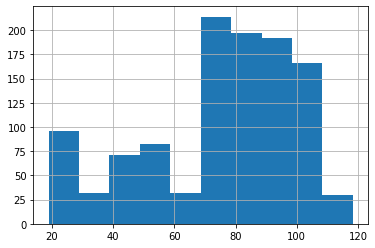

In [35]:
churn_avg_price.hist()
plt.show()

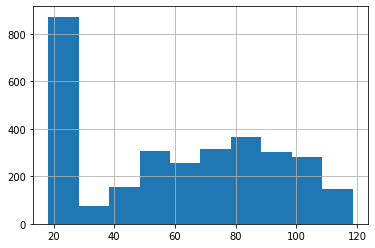

In [36]:
no_churn_avg_price.hist()
plt.show()

__B. Set Hypothesis__

#### Hypothesis 2
- $H_0$: The average monthly charge from churned customers __=__ the average monthly price from customers who stayed
- $H_a$: The average monthly charge from churned customers __!=__ the average monthly price from customers who stayed

__C. Set Alpha__

In [39]:
alpha = .05

__D. Verify Assumptions__

- normal distribution: Yes
- large enough: Yes
- variance: ??

In [40]:
churn_avg_price.var()

617.9259744283776

In [38]:
no_churn_avg_price.var()

953.8134939205495

Variance does not equal

__E. Compute Test Statistics__

In [41]:
t, p = stats.ttest_ind(churn_avg_price, no_churn_avg_price, equal_var = False)
t, p

(14.836135271892125, 9.965244195444622e-48)

In [42]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null")

We reject the null hypothesis


__Conclusion__: We reject the null hypothesis. There is not a difference in average monthly price from customers who churn vs customers who stay.

## Modeling and Evaluation

You are required to establish a baseline accuracy to determine if having a model is better than no model and train and compare at least 3 different models. Document these steps well.

In Your Notebook

- Feature Selection: Are there any variables that seem to provide limited to no additional information? If so, remove them.

- Train (fit, transform, evaluate) multiple different models, varying the model type and hyperparameters.

- Compare evaluation metrics across all the models, and select the ones you want to test using your validate dataframe.

- Based on how your evaluation of your models using the train and validate datasets, choose your best model that you will try with your test data.

- Test the final model (transform, evaluate) on your out-of-sample data (the testing data set). Summarize the performance. Interpret your results.

Draw Conclusions

- Summarize your findings.

- Key takeaways and next steps should be documented here.

In [53]:
train['baseline'] = train.churn_Yes.value_counts().index[0]
train

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,device_protection,tech_support,monthly_charges,total_charges,tenure_by_year,multiple_line_values,part_or_dep_values,streaming_tv_or_movie,security_or_backup_values,gender_Male,churn_Yes,paperless_billing_Yes,baseline
customer_id,,,,,,,,,,,,,,,,,,
3961-SXAXY,3,1,1,0,1,1,1,44.05,44.05,0.083333,1,0,1,1,1,0,1,0
8085-MSNLK,2,2,3,0,62,2,2,113.95,6891.4,5.166667,2,1,3,3,0,0,0,0
3873-WOSBC,4,3,3,0,67,0,0,25.60,1784.9,5.583333,2,1,0,0,1,0,0,0
4544-RXFMG,2,1,2,0,8,1,1,43.45,345.5,0.666667,1,2,1,1,1,0,1,0
8644-XLFBW,1,2,1,1,1,1,1,71.65,71.65,0.083333,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7317-GGVPB,4,2,3,0,71,2,2,108.60,7690.9,5.916667,2,1,3,2,1,1,1,0
6332-FBZRI,4,1,2,0,67,2,2,69.35,4653.25,5.583333,2,2,1,3,1,0,1,0
7554-NEWDD,3,3,3,0,10,0,0,25.70,251.6,0.833333,2,0,0,0,1,0,0,0


In [54]:
baseline_accuracy = (train.baseline == train.churn_Yes).mean()
baseline_accuracy

0.7346062052505966